In [1]:
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import PIL
import sys
import pickle

from tqdm import tqdm_notebook as tqdm
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim import lr_scheduler
from torchsummary import summary

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
#from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
#from albumentations.pytorch import ToTensor


# Plots
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()   # interactive mode

In [2]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid", {'axes.grid' : False})

## Local functions

In [3]:
from dataset import *
from train import train_model
from show import *
from constants import *
from utils import path_to_tuple
from augmentation import tuple_to_pil

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Constants

In [5]:
SEED = 238122

# Loading Data

## Transform data

In [6]:
dataset = FacadesDatasetH5Patches(to_file_path('images/images', 'hdf5'), normalized=True)

# Validation Set

In [7]:
num_crops_per_images = pickle.load(open(to_file_path('crops', 'p'), "rb" ))
crops_from_to_idx = []
from_ = 0
to = 0
for n in num_crops_per_images:
    to += n
    crops_from_to_idx.append((from_, to))
    from_ += n

In [8]:
def img_idx_to_crop_idx(indices):
    return np.array([j for i in indices for j in range(*crops_from_to_idx[i])])

In [9]:
def lenghts_split(size, perc):
    train_l =  int(0.9 * size)
    return train_l, size - train_l

In [10]:
np.random.seed(SEED)
img_indices = np.random.permutation(len(num_crops_per_images))
n_img_train, n_img_val = lenghts_split(len(num_crops_per_images), .9)
train_ind = img_idx_to_crop_idx(img_indices[:n_img_train])
train_ind = train_ind[np.random.permutation(len(train_ind))]
val_ind = img_idx_to_crop_idx(img_indices[n_img_train:])
val_ind = val_ind[np.random.permutation(len(val_ind))]

len(train_ind), len(val_ind)

(4280, 496)

In [11]:
train_dataset = Subset(dataset, train_ind)
val_dataset = Subset(dataset, val_ind)

In [12]:
batch_size = 16

In [13]:
def to_dataloader(dataset):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [14]:
dataloaders = {'train': to_dataloader(train_dataset), 'val': to_dataloader(val_dataset)}

In [15]:
dataset_sizes = {phase: len(dataloaders[phase]) for phase in ['train', 'val']}

In [16]:
dataset_sizes

{'train': 268, 'val': 31}

# Statistics

In [17]:
class_weights = {v: 0 for _, v in dataset.labels.items()}
for data in tqdm(dataloaders['train']):
    lbl = data['label'].to(device)
    for v in class_weights:
        class_weights[v] += (lbl == torch.tensor(v).to(device)).sum().float() / lbl.nelement()
        
for v in class_weights:
    class_weights[v] /= len(dataloaders['train'])

KeyboardInterrupt: 

In [ ]:
label_name_to_value

In [ ]:
class_weights, sum([t.item() for _, t in class_weights.items()])

In [ ]:
weights = torch.tensor([1 - w for _, w in class_weights.items()]).to(device)
weights

# Using AlbuNet

In [17]:
from models import AlbuNet

In [18]:
albunet = AlbuNet(
    num_classes=len(dataset.labels),
    num_filters=16,
    pretrained=True,
    is_deconv=False,
)

## Model details

In [19]:
%%capture catching_output
summary(albunet.to(device), input_size=dataset[0]['image'].shape)

In [20]:
summary_txt = catching_output.stdout
%store summary_txt > "models_summary/albunet_summary.txt"

Writing 'summary_txt' (str) to file 'models_summary/albunet_summary.txt'.


In [21]:
separator = "=" * 10
counter = 0
for l in iter(summary_txt.splitlines()):
    if separator in l:
        counter += 1
    if counter > 1:
        print(l)

Total params: 47,466,948
Trainable params: 47,466,948
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 547.25
Params size (MB): 181.07
Estimated Total Size (MB): 729.07
----------------------------------------------------------------


In [22]:
from torchviz import make_dot

In [23]:
x = torch.randn(dataset[0]['image'].shape).unsqueeze(0).to(device)
y = albunet.to(device)(x)

In [24]:
make_dot(y, dict(albunet.named_parameters())).render('model_viz')

'model_viz.pdf'

# Training

In [25]:
from tensorboardX import SummaryWriter
from loss_and_metric import dice_loss, jaccard_index
writer = SummaryWriter()

In [26]:
criterion = dice_loss#nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(albunet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
label_name_to_value

{'_background_': 0, 'door': 3, 'wall': 1, 'window': 2}

In [28]:
albunet.load_state_dict(torch.load("{}/models/model_albunet_dice_cropped100_256_1024_19.torch".format(path_to_data)))

# Showing Predictions

In [29]:
img_dir = '{}/labels'.format(path_to_data)
img_paths = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir))]
img, lbl = path_to_tuple(img_paths[185], label_name_to_value)

(3024, 4032, 1)


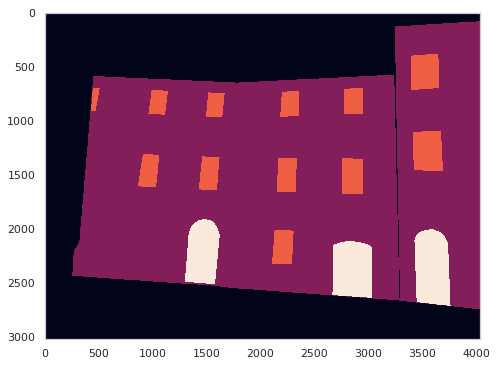

In [41]:
show_img(lbl)

In [31]:
n_rows = pickle.load(open(to_file_path('n_rows', 'p'), 'rb'))
n_crops = pickle.load(open(to_file_path('crops', 'p'), 'rb'))
dataset_full = FacadesDatasetH5Full(to_file_path('images/images', 'hdf5'), n_rows, n_crops, normalized=True)

In [34]:
crop_to_img_list = [img_idx for img_idx, (from_, to) in enumerate(crops_from_to_idx) for i in range(from_, to)]
def crop_to_img(crop_idx):
    return crop_to_img_list[crop_idx]

val_images = sorted(list({crop_to_img(i) for i in val_ind}))
assert len(val_images) == n_img_val

def val_img_predict(idx):
    data = dataset_full[idx]
    image, label_true = data['image'], data['label']
    output = albunet(image.unsqueeze(0).to(device))
    _, label_pred = torch.max(output, 1)
    return image, label_pred, label_true

In [36]:
pred_stats = dict()
for idx in val_images:
    _, pred, target = val_img_predict(idx)
    #pred_cmp = target.squeeze().to(device) == pred
    #pred_acc.append(pred_cmp.sum().item() / pred_cmp.nelement())
    acc_jaccard = jaccard_index(pred, target.squeeze(), n_classes=len(target.unique()))
    pred_stats[idx] = acc_jaccard.mean()

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 21 and 20 in dimension 2 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:83

In [38]:
def show(idx):
    img, label_pred, label_true = val_img_predict(idx)
    acc_jaccard = jaccard_index(label_pred, label_true.squeeze(), n_classes=len(label_true.unique()))
    for chan in range(3):
        img[chan] *= torch.tensor(std)[chan]
        img[chan] += torch.tensor(mean)[chan]
    print(idx, acc_jaccard)
    show_img(img)
    show_img(label_pred.cpu())
    show_img(label_true.cpu())

185 tensor([0.7045, 0.6390, 0.0059, 0.8530, 0.4492])


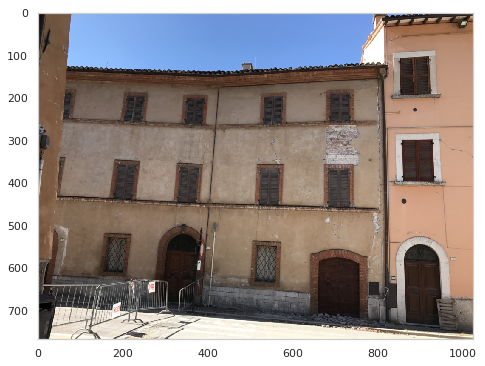

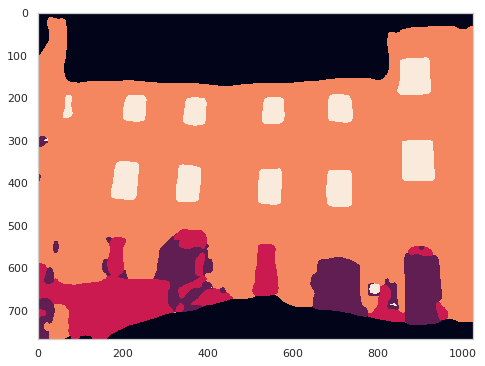

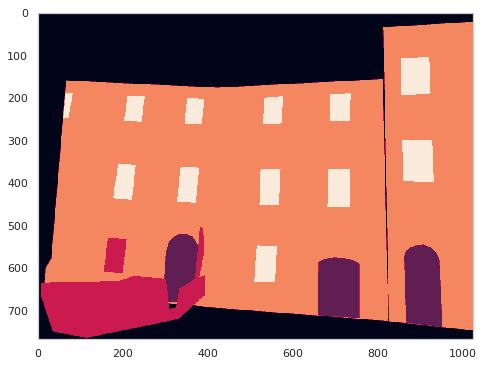

In [152]:
show(max(pred_stats.items(), key=lambda x:x[1])[0])

64 tensor([0.7045, 0.6390, 0.0059, 0.8530, 0.4492])


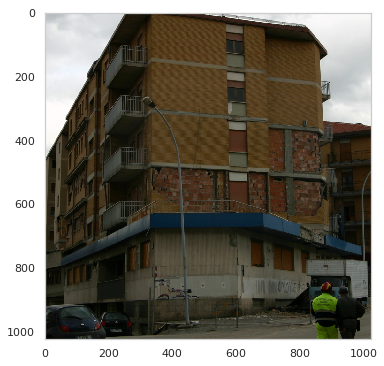

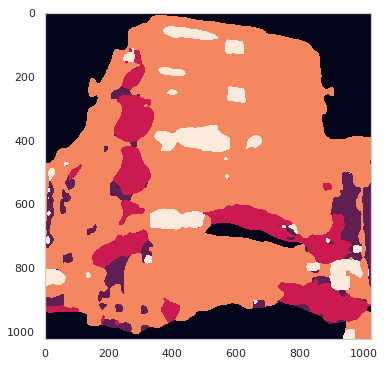

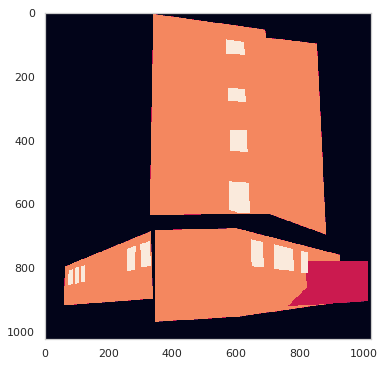

In [153]:
show(min(pred_stats.items(), key=lambda x:x[1])[0])

25 tensor([0.7045, 0.6390, 0.0059, 0.8530, 0.4492])


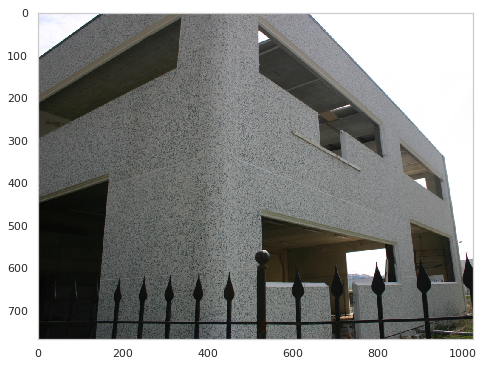

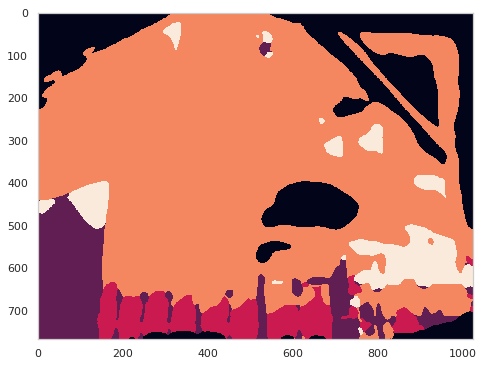

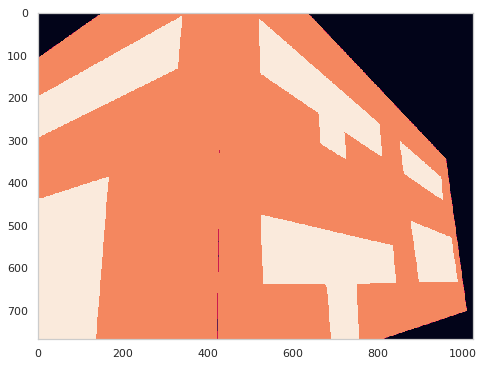

In [154]:
show(25)